# Project description
We fine-tune transfer learning model to classify pictured dishes into 101 classes. The main objective is to beat the performance of [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment) paper using fine-tuning and sharpness minimization techniques. See the data at [`food101`](https://www.tensorflow.org/datasets/catalog/food101) (dataset comprised of 75000 train and 25000 test images). 


Below are the steps of the project.

  1. Use TensorFlow Datasets ([tfds.laod](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)) to download and explore data
  2. Creating preprocessing function for our data
  3. Create data pipeline with tf.data (making our datasets run fast with [tf.data API](https://www.tensorflow.org/guide/data_performance))
  4.  Define TensorBoard and Model Checkpoint, Early Stopping, Learning Rate callbacks
  5. Setting up [Mixed Precision](https://www.tensorflow.org/guide/mixed_precision) policy for fast training 
  6. Loading a feature extraction Transfer Learning Model ([ResNetRS200](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_rs/ResNetRS200)), adding image preprocessing layers, top layers target task
  7. Fine-tuning the feature extractor - experiment models with and without the ideas outlined in [MCdropout](https://arxiv.org/abs/1506.02142) and [Sharpness Aware Minimization](https://arxiv.org/abs/2010.01412).
    * Stochastic predictions with MCdropout
    * Sharpness aware minimization for better generalization
  8. Tracking experiment results on TensorBoard

In [2]:
!pip install tensorflow==2.9.0

      Successfully uninstalled Keras-2.3.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.2.1
    Uninstalling tensorflow-2.2.1:
      Successfully uninstalled tensorflow-2.2.1
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


In [1]:
import tensorflow as tf
print(f'Tensorflow version = {tf.__version__}')

Tensorflow version = 2.9.0


In [2]:
# check GPU
!nvidia-smi

Sun Jan 22 01:36:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.10   Driver Version: 470.141.10   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000001:00:00.0 Off |                  Off |
| N/A   28C    P8    13W / 150W |      0MiB /  8129MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Load and preprocess Data
In this step, we load the data from tensorflow datasets and preprocess the images into accepted shape for our Effnet model. We also batch, shuffle, prefetch, and cache the dataset for fast loading and training.

In [3]:
# import tensorflow datasets
!pip install -q tensorflow_datasets
import tensorflow_datasets as tfds

# check if 'food101' dataset is among tf datasets
dataset_list = tfds.list_builders()
print('food101' in dataset_list)

2023-01-22 01:37:14.516190: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


True


In [4]:
# download 'food101' train, validation and metadata
(train_data, test_data), metadata = tfds.load(name = 'food101',                 # name of the dataset
                                              split = ["train", "validation"],  # split into train and validation
                                              shuffle_files = True,             # shuffle on download
                                              as_supervised = True,             # download train and validation sets as a tuple of (images, labels)
                                              with_info = True)                 # download metadata too

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /home/azureuser/tensorflow_datasets/food101/2.0.0.incompletePNAXJL/food101-train.tfrecord*...:   0%|…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /home/azureuser/tensorflow_datasets/food101/2.0.0.incompletePNAXJL/food101-validation.tfrecord*...: …

Dataset food101 downloaded and prepared to /home/azureuser/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Explore FOOD101 data
* view classnames (the number of classes and get a list of names)
* view image shapes (consistent or not), label shape (one-hot vs label encoded)
* visualise some of the images and check wheter labels mathces

In [5]:
# View the features of the data
print(metadata.features)

# Get class names from the metadata
class_names = metadata.features['label'].names
print(f'Number of classes = {len(class_names)}')  # the number of classes
print(f'Example class names: {class_names[:5]}')  # first 5 classes

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})
Number of classes = 101
Example class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']


In [6]:
# See the type of datasets
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

It seems that the image shapes are not consistent hence the shape = (None, None, 3), and classes are label encoded hence the shape = ().
Furthermore, the datatype of images is uint8 meaning that pixel values are 0-255 (not scaled into 0-1 scale).

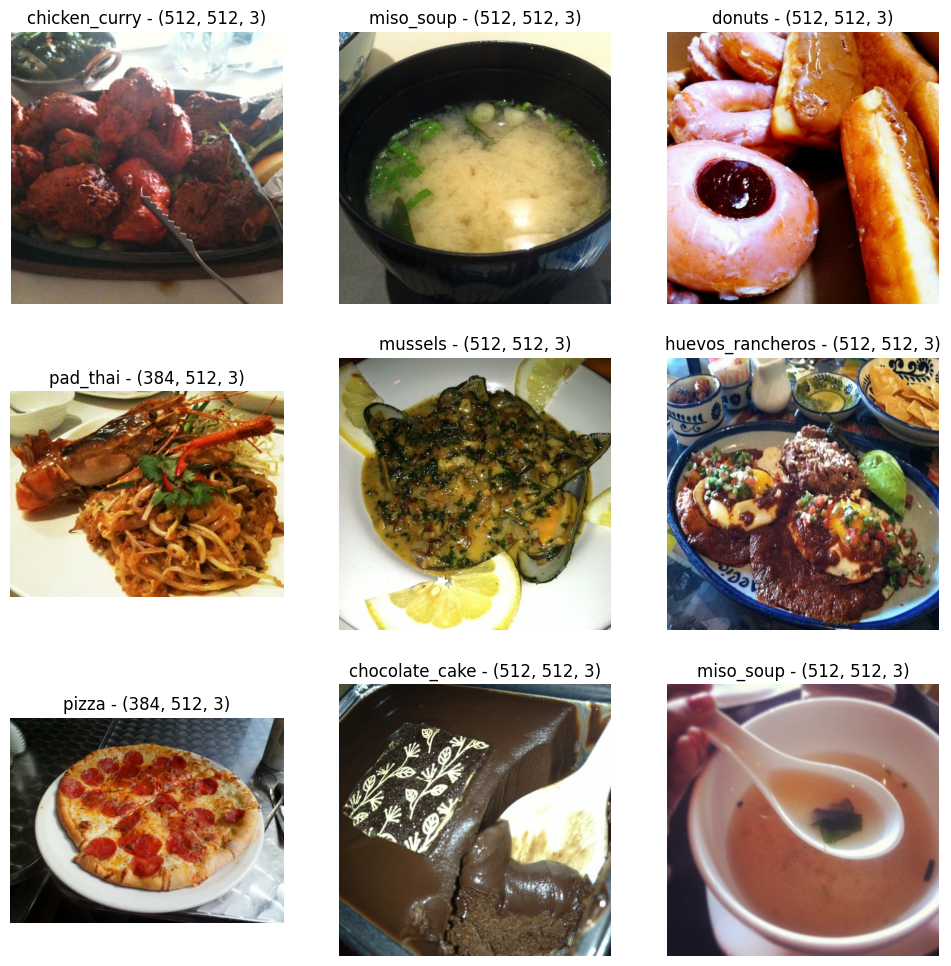

In [7]:
# plot example images and labels to check accuracy of labels
import matplotlib.pyplot as plt
plt.figure(figsize = (12,12))
for i, (image, label) in enumerate(train_data.take(9)):
  shape = image.shape                       # get image shape
  class_name = class_names[label.numpy()]   # get class_name
  # plot the image
  plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.axis(False)
  plt.title(f'{class_name} - {shape}')

It looks like labels matches the images, and some images show a mix of foods which may be challenging to classify. 

Images seem to not have a consistent shape. We want our images to be in the following format:
* float32 data type
* have the same shape,(224, 224, 3)) sutiable for our pretrained feature extractor.
* scaled (values between 0 & 1)

In [8]:
# Create a preprocessing function
def resize_image(image, label, image_shape = 224):
  """
  Convert image datatype from int8 to float32 and resize image shape to (image_shape, image_shape, channel).
  """
  image = tf.cast(tf.image.resize(image, size = (image_shape, image_shape)), dtype = tf.float32)  # reshape and cast dtype to tf.float32
  return image, label # return a tuple of (image,label)

In [9]:
# Check the function output
for image, label in train_data.take(1):
    image, label = resize_image(image, label)
    print(image.shape, image.dtype)

(224, 224, 3) <dtype: 'float32'>


## Batch and Prepare Datasets
  * map() - applies a predefined function to target dataset (e.g. resize_image())
  * batch() - Turn our data into batches of 32 image and label pairs so that it fits into the memory of our GPU.
  * shuffle() - fills a buffer with buffer_size elements (since our dataset is big, we will use buffer size of 1000), then randomly samples elements from this buffer, replaces the selected images with new images.
  * prefetch() - prepares a number of batches for the next step, while model is trained in previous batches(decouples data loading and training)
  * cache() - Caches the elements in the dataset
during the first epoch, the elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data which enables  fast loding.

In [10]:
# Train_data: map -> shuffle -> batch -> prefetch
train_data = train_data.map(map_func = resize_image, num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)#.cache(filename='/content/Food101/train_data')

# Test_data: map -> batch -> prefetch. (no shuffle for future prediction analysis)
test_data = test_data.map(map_func = resize_image, num_parallel_calls = tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# View the datasets
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Set up Mixed Precision
Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs with a compute compability score of 7.0+). To use mixed precision in keras, we need to creat keras.mixed_preicison.Policy.

In [ ]:
# if gpu is not compatible (7+) - do not run this cell
# Set mixed precision global policy
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

## Experiment 1. Baseline Model
 For the baseline model, we keep the feature extractor model as it is, we do not augment the data. The only customization is the addition of top layers to the extractor.

### Creating Callbacks
1. [TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - enable visualisation of experiment results for TensorBoard
2. [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save the full model or weights at given frequency (e.g. each epoch) for external use.

In [15]:
import datetime
import os 
import numpy as np

# Define experiments folder , and experiment name for tensorboard callback
dir_name = 'transfer_learning'
experiment_name = 'baseline_model'
log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M")) # add the current time (up to minutes)to get a unique name
# Create TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)  

# Create model checkpoint
checkpoint_path = 'model_checkpoints/baseline_model.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, # weights will be saved to this path
                                                       save_weights_only = True,   # do not save the full model, weights are sufficient for reloading
                                                       save_best_only = True,     # do not save the model at the epoch if performance degrades
                                                       monitor = 'val_accuracy') # refers to the metric of interest

# create learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr / 10**(epoch/2))

### Load feature extractor and build the Baseline Model
`Note` - Since we are using mixed precision, we will need to define seperate softmax output layer with tf.float32 datatype at the end. 

In [16]:
from tensorflow.keras import layers

# Create base model
image_shape = (224, 224, 3)
base_model_resnet = tf.keras.applications.ResNetRS200(include_top=False)
base_model_resnet.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=image_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model_resnet(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
resnet_model = tf.keras.Model(inputs, outputs)

# Compile the model
resnet_model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
resnet_model.summary()

367574712/367574712 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet-rs-200 (Functional)  (None, None, None, 2048)  91337248  
                                                                 
 pooling_layer (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               


In [17]:
# Check trainable layers
for layer_num, layer in enumerate(resnet_model.layers):
  print(layer_num, layer.name, '\n\t' ,layer.trainable)

0 input_layer 
	 True
1 resnet-rs-200 
	 False
2 pooling_layer 
	 True
3 dense 
	 True
4 softmax_float32 
	 True


In [18]:
from warnings import filterwarnings
filterwarnings('ignore')

# Compile the model
resnet_model.compile(loss="sparse_categorical_crossentropy", # labels are "label-encoded"
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
# Fit the model
initial_epochs = 3
history_baseline = resnet_model.fit(train_data, 
                                      validation_data = test_data,
                                      epochs = initial_epochs,
                                      steps_per_epoch=len(train_data),
                                      validation_steps=int(0.15 * len(train_data)),
                                      callbacks = [tensorboard_callback, checkpoint_callback, lr_schedule])

Epoch 1/3
2368/2368 [==============================] - 1316s 489ms/step - loss: 1.4995 - accuracy: 0.6199 - val_loss: 0.9895 - val_accuracy: 0.7335 - lr: 0.0010
Epoch 2/3
2368/2368 [==============================] - 1146s 484ms/step - loss: 0.9186 - accuracy: 0.7592 - val_loss: 0.8802 - val_accuracy: 0.7646 - lr: 3.1623e-04
Epoch 3/3
2368/2368 [==============================] - 1151s 486ms/step - loss: 0.8072 - accuracy: 0.7942 - val_loss: 0.8513 - val_accuracy: 0.7686 - lr: 3.1623e-05


2023-01-17 22:32:47.592838: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-01-17 22:33:40.383402: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [19]:
# Evaluate the baseline model on the full test dataset
base_result = resnet_model.evaluate(test_data)

790/790 [==============================] - 331s 419ms/step - loss: 0.8498 - accuracy: 0.7696


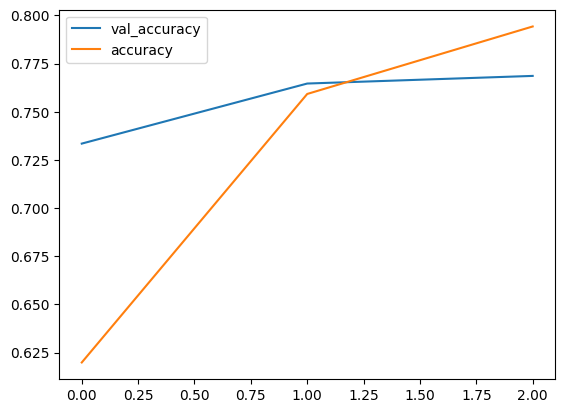

In [21]:
# plot the performance
import pandas as pd
pd.DataFrame(history_baseline.history)[['val_accuracy','accuracy']].plot()

In [22]:
# Save the model in case runtime error
model_path = 'models/baseline_model'
resnet_model.save(model_path)

INFO:tensorflow:Assets written to: models/baseline_model/assets


## Experiment 2. Fine-Tune the top layers

Even without fine-tuning the ResNetRS200 model, we are getting a similar performance with Deepfood paper despite overfitting to the train data. 

We make following changes to the model.
1. Add EarlyStoppingCallback - will stop training if the metric stop to improve after a given steps
2. ReduceLROnPlateau  - reduce learning rate when validation loss stops improving
3. Unfreeze last 20 layers at once



In [33]:
# Tensorboard callback
log_dir = os.path.join('transfer_learning', 'experiment_2_fine_tune',  datetime.datetime.now().strftime("%Y%m%d-%H%M"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

# Create early stopping criteria (stop if no improvement in validation loss for 5 epochs)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                       min_delta = 0,
                                                       patience = 2,
                                                       restore_best_weights = True)

# Create ModelCheckpoint callback to save best model during training
exp2_checkpoint_path = "model_checkpoints/experiment_2_fine_tune.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(exp2_checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Create learning rate reduction callback  - reduce 3 times if performance stops improving for 2 epochs
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                              patience = 1, 
                                                              factor = 0.5,
                                                              min_lr = 1e-7,
                                                              verbose = 1)


In [34]:
# unfreeze top 20 layers
base_model_resnet.trainable = True
for layer in base_model_resnet.layers[:-20]:
  layer.trainable = False

# recompile the model
resnet_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                         metrics = ['accuracy'])
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet-rs-200 (Functional)  (None, None, None, 2048)  91337248  
                                                                 
 pooling_layer (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 91,544,197
Trainable params: 6,769,253
Non-trai

In [36]:
# fit the model starting for 5 more epochs starting from the last training epoch (3)
fine_tune_epochs = initial_epochs + 5
history_experimet_2 =  resnet_model.fit(train_data, 
                       steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data), # can be reduced if time is a concern
                        epochs = fine_tune_epochs,
                        initial_epoch = history_baseline.epoch[-1],
                        callbacks = [tensorboard_callback, model_checkpoint, 
                                        learning_rate_callback, early_stop_callback])


Epoch 3/8
2368/2368 [==============================] - 1496s 631ms/step - loss: 0.7981 - accuracy: 0.7890 - val_loss: 0.7994 - val_accuracy: 0.7813 - lr: 1.0000e-04
Epoch 4/8
2368/2368 [==============================] - 1480s 625ms/step - loss: 0.6830 - accuracy: 0.8182 - val_loss: 0.7545 - val_accuracy: 0.7899 - lr: 1.0000e-04
Epoch 5/8
2368/2368 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8714
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2368/2368 [==============================] - 1350s 570ms/step - loss: 0.4797 - accuracy: 0.8714 - val_loss: 0.7826 - val_accuracy: 0.7845 - lr: 1.0000e-04
Epoch 6/8
2368/2368 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9497
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999

In [37]:
# evaluate the performance on full test data after finetuning
resnet_model.evaluate(test_data)

790/790 [==============================] - 329s 416ms/step - loss: 0.7545 - accuracy: 0.7899


[0.7545395493507385, 0.7899010181427002]

The fine-tuned (only 20 layers trainable) model outperforms the deepfood paper after just 5 iterations of training.

## Experiment 3. Data augmentation + Fine-tuning

We have a huge gap between train and test accuracy in experiment 2 suggesting a significant overfitting problem. We can do following things to reduce the overfitting

  1. perform data augmentation (preprocessing layers) to increase the diversity of data in train set.
  2. adjust parameters of callbacks - earlytermination and reducelronplateau, optimizer regularization (e.g., AdamW - Adam with [Decoupled Weight Decay Regularization](https://arxiv.org/pdf/1711.05101.pdf)), [Sharpness aware minimization] (https://arxiv.org/abs/2010.01412)for generalization
  3. reduce complexity - unfreeze less layers
Next experiment will try augmentation with less number of trainable layers to reduce overfitting.

In [53]:
# Tensorboard callback
log_dir = os.path.join('transfer_learning', 'exp_3_data_augment',  datetime.datetime.now().strftime("%Y%m%d-%H%M"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

# Create early stopping criteria
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                       min_delta = 0,
                                                       patience = 2,
                                                       restore_best_weights = True)
# Create ModelCheckpoint callback to save best model during fine-tuning
aug_checkpoint_path = "model_checkpoints/exp3_augmented_model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(aug_checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_accuracy")
# Create learning rate reduction callback  - reduce 5 times if performance stops improving for 2 epochs
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                              patience = 1, 
                                                              factor = 0.3,
                                                              min_lr = 1e-7,
                                                              verbose = 1)


In [62]:
import tensorflow_addons as tfa

# unfreeze layers of the base model
base_model_resnet.trainable = True
for layer in base_model_resnet.layers[:-15]:
  layer.trainable  = False

# create data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2)])

# add input, preprocessing, and output layers
inputs = layers.Input(shape = image_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = base_model_resnet(x, training = False) 
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling')(x)

# Add activation as a seperate layer to the dense output
outputs = layers.Dense(len(class_names))(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_layer")(outputs)

# Create a sequential Model from inputs and outputs
baseline_model = tf.keras.Model(inputs, outputs)

# compile the model 
baseline_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ['accuracy'])
# view the model summary
baseline_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet-rs-200 (Functional)  (None, None, None, 2048)  91337248  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 dense_11 (Dense)            (None, 101)               206949    
                                                                 
 softmax_layer (Activation)  (None, 101)               0         
                                                          

In [63]:
# fit the model (this time we will run from the epoch 0)
fine_tune_epochs = 7
history_augmented = baseline_model.fit( train_data, 
                                        steps_per_epoch = len(train_data),
                                        validation_data = test_data,
                                        validation_steps = int(0.25*len(test_data)),
                                        epochs = fine_tune_epochs,
                                        callbacks = [tensorboard_callback, model_checkpoint, 
                                                    learning_rate_callback, early_stop_callback] )


Epoch 1/7
2368/2368 [==============================] - 1280s 531ms/step - loss: 1.8106 - accuracy: 0.5486 - val_loss: 1.0366 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 2/7
2368/2368 [==============================] - 1255s 530ms/step - loss: 1.3407 - accuracy: 0.6514 - val_loss: 0.9442 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 3/7
2368/2368 [==============================] - 1253s 529ms/step - loss: 1.2047 - accuracy: 0.6823 - val_loss: 0.9318 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 4/7
2368/2368 [==============================] - 1256s 530ms/step - loss: 1.1231 - accuracy: 0.6997 - val_loss: 0.9067 - val_accuracy: 0.7546 - lr: 0.0010
Epoch 5/7
2368/2368 [==============================] - 1256s 530ms/step - loss: 1.0628 - accuracy: 0.7155 - val_loss: 0.8725 - val_accuracy: 0.7575 - lr: 0.0010
Epoch 6/7
2368/2368 [==============================] - 1114s 470ms/step - loss: 1.0158 - accuracy: 0.7254 - val_loss: 0.8843 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 

INFO:tensorflow:Assets written to: model_checkpoints/exp3_augmented_model.ckpt/assets
INFO:tensorflow:Assets written to: model_checkpoints/exp3_augmented_model.ckpt/assets
INFO:tensorflow:Assets written to: model_checkpoints/exp3_augmented_model.ckpt/assets
INFO:tensorflow:Assets written to: model_checkpoints/exp3_augmented_model.ckpt/assets
INFO:tensorflow:Assets written to: model_checkpoints/exp3_augmented_model.ckpt/assets


Tensorflow version 2.9 seems to have a bug. It runs very slow and gives warnings with preprocessing layers, which does not occur in the earlier versions.

## Experiment 4 -  Sharpness aware minimization

Image augmentation worsened the performance and caused underfitting. This may be because the augmentation changes the distribution of the data too much, so the model is not even able to learn the train data well.

Next experiment:

  1. adjust parameters of callbacks - earlytermination and reducelronplateau.
  2. Use [Sharpness Aware minimization](https://arxiv.org/pdf/2010.01412v3.pdf) for better generalization.


This experiment implements Sharpness Aware minimization where the model is simultaneously minimizes loss value and loss sharpness to improve generaliation of the model. (Definition: A flat minimizer $\hat{w}$ = 
the function varies slowly in a relatively large neighborhood of $\hat{w}$, and a sharp minimizer $\hat{w}$ = 
 function increases rapidly in a small neighborhood of the minimizer.) We also adjust parameters of callbacks - earlytermination and reducelronplateau to make it more regularized.
  2. 

In [ ]:
# Tensorboard callback
log_dir = os.path.join('transfer_learning', 'sharpness',  datetime.datetime.now().strftime("%Y%m%d-%H%M"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
# Create early stopping criteria
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                       min_delta = 0,
                                                       patience = 4,
                                                       restore_best_weights = True)
# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "data_aug_fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_accuracy")
# Create learning rate reduction callback  - reduce 5 times if performance stops improving for 2 epochs
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                              patience = 2, 
                                                              factor = 0.1,
                                                              min_lr = 1e-7,
                                                              verbose = 1)


In [130]:
# Tensorboard callback
log_dir = os.path.join('transfer_learning', 'SAMM',  datetime.datetime.now().strftime("%Y%m%d-%H%M"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

# Create early stopping criteria
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                       min_delta = 0,
                                                       patience = 2,
                                                       restore_best_weights = True)

# Learning rate schedule
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                   factor=0.5,
                                                   patience=1)

train_callbacks = [tensorboard_callback, early_stop_callback, lr_schedule]

In [131]:
# Unfreeze layers of the base model
base_model_resnet.trainable = True
for layer in base_model_resnet.layers[:-30]:
  layer.trainable  = False

# Add input, preprocessing, and output layers
inputs = layers.Input(shape = (224,224,3), name = 'input_layer')
x = base_model_resnet(inputs, training = False) 
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling')(x)
# Add activation as a seperate layer to the dense output
outputs = layers.Dense(len(class_names))(x) 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_layer")(outputs)

# Create a sequential Model from inputs and outputs
resnet_model = tf.keras.Model(inputs, outputs)

# Compile the model 
resnet_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer = 'adam',
                     metrics = ['accuracy'])

SAMM model below implements the logic of the sharpness aware minimization based on the algorithm given in the paper with L-2 norm, i.e., p=2 (see equation 2 of the paper). $\rho$ represents the size measure for the neighborhood of minimum. For large $\rho$, the algorithm seeks parameters having uniformly low loss value in relatively larger neighborhood ($\rho$ = 0.05 is default value used in the paper). [Click here](https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow/blob/main/SAM.ipynb) to see the original repo for tensorflow application of the paper.

In [132]:
tf.config.run_functions_eagerly(False)
class SAMModel(tf.keras.Model):
    def __init__(self, resnet_model, rho=0.05):
        """
        p, q = 2 for optimal results as suggested in the paper
        (Section 2)
        """
        super(SAMModel, self).__init__()
        self.resnet_model = resnet_model
        self.rho = rho

    def train_step(self, data):
        (images, labels) = data
        e_ws = []
        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.resnet_model.trainable_variables
        gradients = tape.gradient(loss, trainable_params) # find the gradients at w
        grad_norm = self._grad_norm(gradients)            # calculate epsilon_w by equation 2 of paper --> e_w = rho * grad/||grad
        scale = self.rho / (grad_norm + 1e-12)

        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)    
            
        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)
        
        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))
        
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}
    def test_step(self, data):
        (images, labels) = data
        predictions = self.resnet_model(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

In [133]:
# Build the SAMM model
model = SAMModel(resnet_model, rho = 0.1)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.resnet_model.summary()
         

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet-rs-200 (Functional)  (None, None, None, 2048)  91337248  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 dense_18 (Dense)            (None, 101)               206949    
                                                                 
 softmax_layer (Activation)  (None, 101)               0         
                                                                 
Total params: 91,544,197
Trainable params: 12,281,957
Non-trainable params: 79,262,240
_____________________________________

In [ ]:
# fit the model for 3 epochs
model.fit(train_data,
                    validation_data=test_data,
                    callbacks=train_callbacks,
                    epochs=3) 

In [139]:
# evaluate the model 
model.evaluate(test_data)

790/790 [==============================] - 328s 415ms/step - loss: 0.7022 - accuracy: 0.8051


[0.7022401094436646, 0.8050693273544312]

## Experiment 5 - Monte Carlo Dropout

This section implements [MC dropout](https://arxiv.org/abs/1506.02142) method for reducing uncertainity in the model predicitons. This method is used to boost the performance of any trained model without having to retrain it. The idea is to keep the dropout layer active while predicting and to generate multiple predictions over the test set. Since the dropout layer is active, we will get multiple different predictions, and we can average over the predictions to get a monto carlo estimate that is generally more reliable than the result for the single prediction.

Implementation: Create a custom dropout layer using subclassing and set training to True.

`` class MCDropout(tf.keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training = True)``


In [24]:
# Tensorboard callback
log_dir = os.path.join('transfer_learning', 'mc_droput',  datetime.datetime.now().strftime("%Y%m%d-%H%M"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

# Create early stopping criteria
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                       min_delta = 0,
                                                       patience = 2,
                                                       restore_best_weights = True)
# # Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "model_checkpoints/SAMM_dropou_ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_accuracy")
# learning rate schedule
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                   factor=0.5,
                                                   patience=1)

train_callbacks = [tensorboard_callback, early_stop_callback, lr_schedule]

In [25]:
# Create a dropout layer and set training = True
class MCDropout(tf.keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training = True)

In [26]:
# Create Base Model
input_shape = (224, 224, 3)
base_model_resnet = tf.keras.applications.ResNetRS200(include_top=False)
base_model_resnet.trainable = True # freeze base model layers
for layer in base_model_resnet.layers[:-30]:
  layer.trainable = False

# Create Functional Model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model_resnet(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x =  MCDropout(rate = 0.5)(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
resnet_model = tf.keras.Model(inputs, outputs)

# Compile the model
resnet_model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
resnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet-rs-200 (Functional)  (None, None, None, 2048)  91337248  
                                                                 
 pooling_layer (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 101)               206949    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                         

In [28]:
# Add the custom dropout layer to the SAMM model

class SAMresnet(tf.keras.Model):
  def __init__(self, resnet_layer, rho = 0.05):
    super(SAMresnet, self).__init__()
    self.resnet_model = resnet_layer
    self.rho = rho
    # self.build(input_shape)
  def call(self, input_tensor, training = False):
    return self.resnet_model(input_tensor)
  
  def train_step(self, data):
      (images, labels) = data
      e_ws = []
      with tf.GradientTape() as tape:
          predictions = self.resnet_model(images)
          loss = self.compiled_loss(labels, predictions)
      trainable_params = self.resnet_model.trainable_variables
      gradients = tape.gradient(loss, trainable_params) # find the gradients at w
      grad_norm = self._grad_norm(gradients)            # calculate epsilon_w by equation 2 of paper --> e_w = rho * grad/||grad
      scale = self.rho / (grad_norm + 1e-12)

      for (grad, param) in zip(gradients, trainable_params):
          e_w = grad * scale
          param.assign_add(e_w)
          e_ws.append(e_w)

      with tf.GradientTape() as tape:
          predictions = self.resnet_model(images)
          loss = self.compiled_loss(labels, predictions)    
          
      sam_gradients = tape.gradient(loss, trainable_params)
      for (param, e_w) in zip(trainable_params, e_ws):
          param.assign_sub(e_w)
      
      self.optimizer.apply_gradients(
          zip(sam_gradients, trainable_params))
      
      self.compiled_metrics.update_state(labels, predictions)
      return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
      (images, labels) = data
      predictions = self.resnet_model(images, training=False)
      loss = self.compiled_loss(labels, predictions)
      self.compiled_metrics.update_state(labels, predictions)
      return {m.name: m.result() for m in self.metrics}

  def _grad_norm(self, gradients):
      norm = tf.norm(
          tf.stack([
              tf.norm(grad) for grad in gradients if grad is not None
          ])
      )
      return norm
model = SAMresnet(resnet_layer = resnet_model, rho = 0.05)
model.compile(loss= 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model.resnet.summary()

model.build(input_shape = (None, 224,224,3))
model.summary()

Model: "sa_mresnet_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 101)               91544197  
                                                                 
Total params: 91,544,197
Trainable params: 12,281,957
Non-trainable params: 79,262,240
_________________________________________________________________


In [ ]:
# Fit the model on train data (more epochs since we are using dropout layer)
model.fit(train_data,
          epochs = 6,
          validation_data = test_data,
          callbacks = train_callbacks,
          verbose = 0)

In [ ]:
# Predictions with MC Dropout (10 stochastic predictions per image)
batch_accuracy = []
for batch, (images, labels) in enumerate(test_data):
    preds = tf.argmax(tf.reduce_mean(tf.stack([model(images) for _ in range(10)]), axis = 0),axis = -1)
    accuracy = tf.reduce_mean(tf.cast(preds == labels, dtype=tf.float32)).numpy()
    print(f'Batch {batch} \t accuracy = {accuracy}\n\n')
    batch_accuracy.append(accuracy)

test_accuracy = tf.reduce_mean(batch_accuracy).numpy()
print(f'Accuracy of the model on test data is {test_accuracy}')

In [83]:
# Evaluate without stacking
deterministic_accuracy = model.evaluate(test_data)

# Calculate the performance improvement with MCDropout
print(f'Deterministic accuarcy = {np.round(100 * deterministic_accuracy[1], 3)}')
print(f'MonteCarlo accuracy = {np.round(100 * test_accuracy, 3)}')
print(f'With MCDropout, prediction accuracy increases by {np.round(100 * (test_accuracy-deterministic_accuracy[1]),3)}%')

Deterministic accuarcy = 77.699
MonteCarlo accuracy = 79.953
With MCDropout, prediction accuracy increases by 2.254%


# Top-5 Accuracy
Top-5 accuracte if the correct label is within top 5 likely predicted classes.

In [ ]:
# calculate top-k accuracy
metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
for batch, (images, labels) in enumerate(test_data.take(100)):
    preds = tf.reduce_mean(tf.stack([model(images) for _ in range(10)]), axis = 0)
    metric.update_state(labels, preds)
    print(f'Updated Top-5 Accuracy after Batch {batch} - {metric.result().numpy()}')

In [393]:
print(f'Top 5 Accuracy is {metric.result()}')

Top 5 Accuracy is 0.9534375071525574


# View and compare experiment results with Tensorboard

In [394]:
from azureml.tensorboard import Tensorboard

# The TensorBoard constructor takes an array of jobs, so be sure and pass it in as a single-element array here
tb = Tensorboard([], local_root='transfer_learning', port=6006)

# If successful, start() returns a string with the URI of the instance.
tb.start()

https://food101-6006.eastus2.instances.azureml.ms


'https://food101-6006.eastus2.instances.azureml.ms'